### 데이터 로드

In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import probplot, bartlett, levene
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
import pandasql as ps

df = fdr.DataReader('KS11','2014','2022-05-09')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800.0
2014-01-03,1963.719971,1964.630005,1936.150024,1946.140015,1946.140015,188500.0
2014-01-06,1947.619995,1961.849976,1943.739990,1953.280029,1953.280029,193600.0
2014-01-07,1947.650024,1965.739990,1947.079956,1959.439941,1959.439941,193000.0
2014-01-08,1965.500000,1966.949951,1950.020020,1958.959961,1958.959961,217100.0
...,...,...,...,...,...,...
2022-04-29,2669.179932,2696.100098,2664.060059,2695.050049,2695.050049,975000.0
2022-05-02,2669.209961,2689.909912,2667.850098,2687.449951,2687.449951,873400.0
2022-05-03,2690.159912,2702.100098,2680.459961,2680.459961,2680.459961,883100.0


In [2]:
data = pd.DataFrame(df['Close'])
data.isnull().sum()

Close    1
dtype: int64

In [3]:
data = data.interpolate()
data.isnull().sum()

Close    0
dtype: int64

In [4]:
data_2013 = fdr.DataReader('KS11','2013-12-30','2014-01-03')
data_2013

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-30,2004.319946,2011.339966,1998.609985,2011.339966,2011.339966,172200
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800


In [5]:
data = data.rename(columns = {"Close":'당일종가'})
data['전일종가'] = data['당일종가'].shift()
data['전일종가'][0] = data_2013[data_2013.index == '2013-12-30']['Close'] # 결측치 제거를 위해 2013년 마지막 날 코스피 종가 데이터 입력
data

,당일종가,전일종가
Date,,
2014-01-02,1967.189941,2011.339966
2014-01-03,1946.140015,1967.189941
2014-01-06,1953.280029,1946.140015
2014-01-07,1959.439941,1953.280029
2014-01-08,1958.959961,1959.439941
...,...,...
2022-04-29,2695.050049,2667.489990
2022-05-02,2687.449951,2695.050049
2022-05-03,2680.459961,2687.449951


In [6]:
new_order = ['전일종가','당일종가']
data = data[new_order]
data['change'] = data['당일종가']/data['전일종가']
data

C:\Users\이동현\AppData\Local\Temp\ipykernel_20348\2874607138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['change'] = data['당일종가']/data['전일종가']


,전일종가,당일종가,change
Date,,,
2014-01-02,2011.339966,1967.189941,0.978049
2014-01-03,1967.189941,1946.140015,0.989299
2014-01-06,1946.140015,1953.280029,1.003669
2014-01-07,1953.280029,1959.439941,1.003154
2014-01-08,1959.439941,1958.959961,0.999755
...,...,...,...
2022-04-29,2667.489990,2695.050049,1.010332
2022-05-02,2695.050049,2687.449951,0.997180
2022-05-03,2687.449951,2680.459961,0.997399


### 시계열 분석을 위한 검증 Class


ADF Test Results

ADF Statistic: -29.241567679691233
p-value: 0.0
Critical Values: {'1%': -3.433547028919612, '5%': -2.8629522934224085, '10%': -2.5675218415927885}
Is data stationary?: Yes


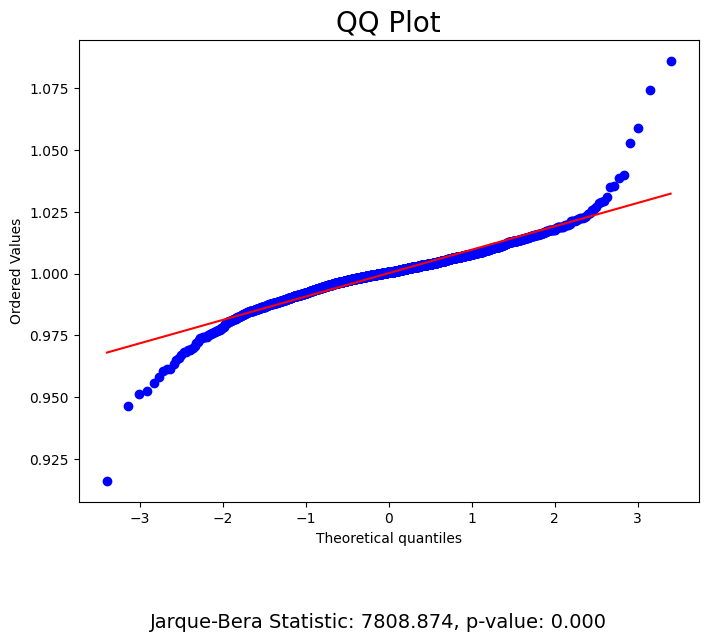

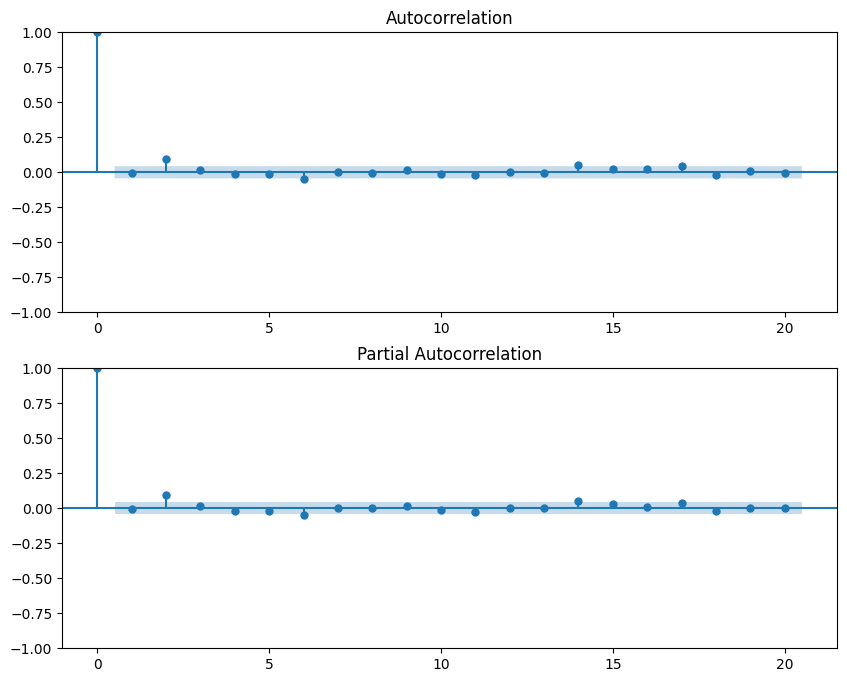


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 8.226633273093579e-22
Equal variance? No


In [7]:
class TimeSeriesTester:
    def __init__(self, data):
        self.data = data

    def plot_qq_plot(self):
        plt.figure(figsize=(8, 6))
        probplot(self.data, dist='norm', plot=plt)

        # Jarque-Bera Test for normality
        jb_stat, jb_pvalue = jarque_bera(self.data)
        jb_result = f"Jarque-Bera Statistic: {jb_stat:.3f}, p-value: {jb_pvalue:.3f}"
        # Plot title and result
        plt.title("QQ Plot", fontsize=20)
        plt.figtext(0.5, -0.1, jb_result, ha='center', fontsize=14)
        plt.show()

    def plot_acf_pacf(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(self.data, ax=ax1, lags=20)
        plot_pacf(self.data, ax=ax2, lags=20)
        plt.show()

    def test_stationarity(self):
        adf_result = adfuller(self.data)
        adf_test_results = {
            "ADF Statistic": adf_result[0],
            "p-value": adf_result[1],
            "Critical Values": adf_result[4],
            "Is data stationary?": "Yes" if adf_result[1] <= 0.05 else "No"}
        print("\nADF Test Results\n")
        for key, value in adf_test_results.items():
            print(f"{key}: {value}")

    def test_homoscedasticity(self):
        n = len(self.data)
        group1 = self.data[:n // 2]
        group2 = self.data[n // 2:]

        # Jarque-Bera Test for normality
        jb_test = jarque_bera(self.data)
        is_normal = jb_test[1] > 0.05

        if is_normal:
            homoscedasticity_result = bartlett(group1, group2)
            test_name = 'Bartlett Test'
        else:
            homoscedasticity_result = levene(group1, group2)
            test_name = 'Levene Test'

        equal_variance = homoscedasticity_result.pvalue > 0.05
        print("\nHomoscedasticity Test Results\n")
        print("Test used:", test_name)
        print("Test p-value:", homoscedasticity_result.pvalue)
        print("Equal variance?", "Yes" if equal_variance else "No")

# 클래스 인스턴스 생성 
tester = TimeSeriesTester(data['change']) 

tester.test_stationarity()
tester.plot_qq_plot() # This will also print Jarque-Bera Test results
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 코스피의 변동률은 white noise 형태를 보이므로, 분석 불가

- 이전에 실패했던 원인을 찾았으니, 코스피의 종가 데이터로 리뷰 진행

### 코스피의 당일 종가 분석

In [107]:
df = fdr.DataReader('KS11','2014','2023-08-10')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800.0
2014-01-03,1963.719971,1964.630005,1936.150024,1946.140015,1946.140015,188500.0
2014-01-06,1947.619995,1961.849976,1943.739990,1953.280029,1953.280029,193600.0
2014-01-07,1947.650024,1965.739990,1947.079956,1959.439941,1959.439941,193000.0
2014-01-08,1965.500000,1966.949951,1950.020020,1958.959961,1958.959961,217100.0
...,...,...,...,...,...,...
2023-08-03,2624.760010,2625.449951,2591.300049,2605.389893,2605.389893,789400.0
2023-08-04,2606.169922,2612.300049,2598.379883,2602.800049,2602.800049,645800.0
2023-08-07,2591.580078,2607.360107,2580.709961,2580.709961,2580.709961,504100.0


In [108]:
print(df.isnull().sum())

query = '''
select * from df
where Close is null
'''

print(ps.sqldf(query, locals())) # 임시 공휴일

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
                         Date  Open  High   Low Close Adj Close Volume
0  2015-08-14 00:00:00.000000  None  None  None  None      None   None


In [109]:
df = df.interpolate() # 보간법 처리
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64



ADF Test Results

ADF Statistic: -1.5936479743089076
p-value: 0.48678355702636467
Critical Values: {'1%': -3.4331536417276274, '5%': -2.8627785955546137, '10%': -2.5674293588855925}
Is data stationary?: No


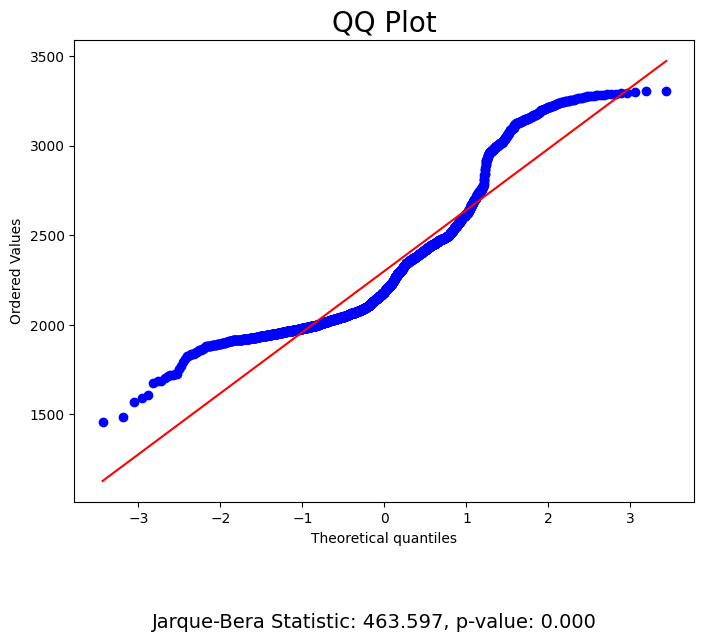

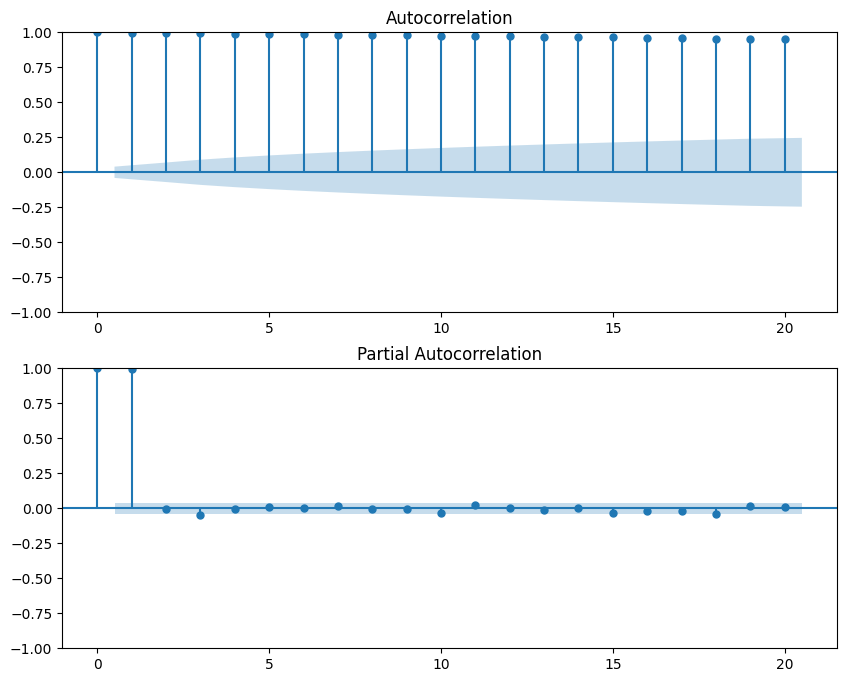


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 3.358294194728403e-94
Equal variance? No


In [110]:
tester = TimeSeriesTester(df['Close']) 

tester.test_stationarity()
tester.plot_qq_plot()
tester.plot_acf_pacf()
tester.test_homoscedasticity()


ADF Test Results

ADF Statistic: -10.024555583651734
p-value: 1.6451171982712467e-17
Critical Values: {'1%': -3.4331536417276274, '5%': -2.8627785955546137, '10%': -2.5674293588855925}
Is data stationary?: Yes


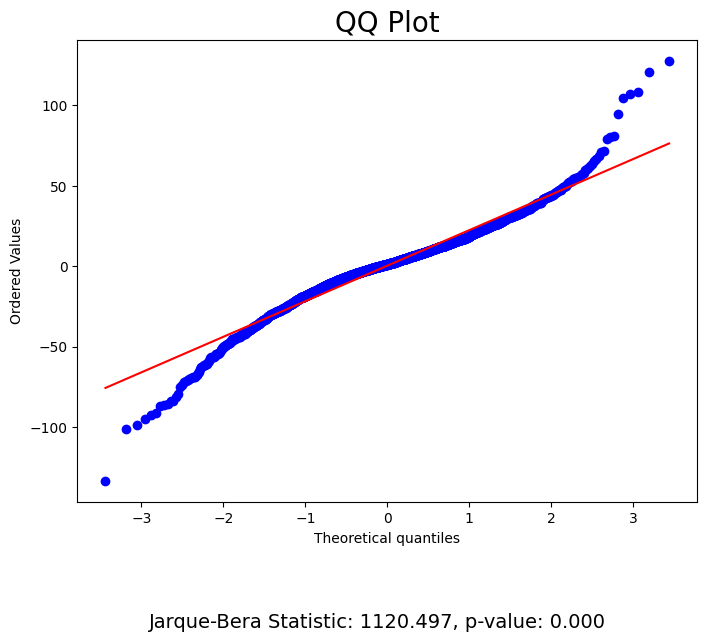

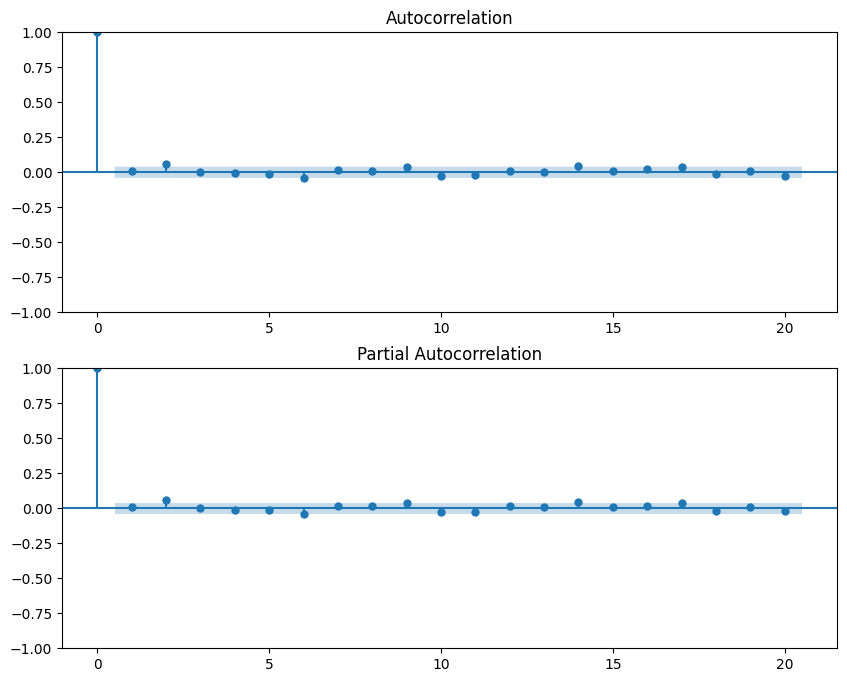


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 4.032010188995509e-46
Equal variance? No


In [169]:
tester = TimeSeriesTester(np.diff(df['Close']))
tester.test_stationarity()
tester.plot_qq_plot()
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 동일한 문제 발생

- 코스피의 변동률 혹은 종가 단일 데이터만으로는 ARIMA 계열 모델 사용 불가

- 원문 자체를 구현하는 것으로 루트 변경

# 논문 구현 시작

## 데이터 로드 및 간단한 전처리

In [117]:
data = fdr.DataReader('KS11','2012','2023-08-10')
print(data)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2012-01-02  1831.689941  1837.810059  1814.550049  1826.369995  1826.369995   
2012-01-03  1846.560059  1875.410034  1846.560059  1875.410034  1875.410034   
2012-01-04  1883.479980  1884.689941  1866.219971  1866.219971  1866.219971   
2012-01-05  1869.420044  1875.969971  1860.569946  1863.739990  1863.739990   
2012-01-06  1867.119995  1867.119995  1824.290039  1843.140015  1843.140015   
...                 ...          ...          ...          ...          ...   
2023-08-03  2624.760010  2625.449951  2591.300049  2605.389893  2605.389893   
2023-08-04  2606.169922  2612.300049  2598.379883  2602.800049  2602.800049   
2023-08-07  2591.580078  2607.360107  2580.709961  2580.709961  2580.709961   
2023-08-08  2598.290039  2601.409912  2568.149902  2573.979980  2573.979980   
2023-08-09  2580.600098  2608.979980  2576.209961  2

In [118]:
data = data.interpolate() # 결측치 처리(2015-08-14)
data = data.rename(columns = {"Close":'당일종가'})
data['전일종가'] = data['당일종가'].shift()
data['전일종가'][0] = data_2013[data_2013.index == '2013-12-30']['Close'] # 결측치 제거를 위해 2013년 마지막 날 코스피 종가 데이터 입력
data['change'] = (data['당일종가']/data['전일종가'])
data['log_change'] = np.log(data['change'])

## 간단한 EDA


ADF Test Results

ADF Statistic: -22.77643113093351
p-value: 0.0
Critical Values: {'1%': -3.43264575500919, '5%': -2.862554307267278, '10%': -2.567309945727228}
Is data stationary?: Yes


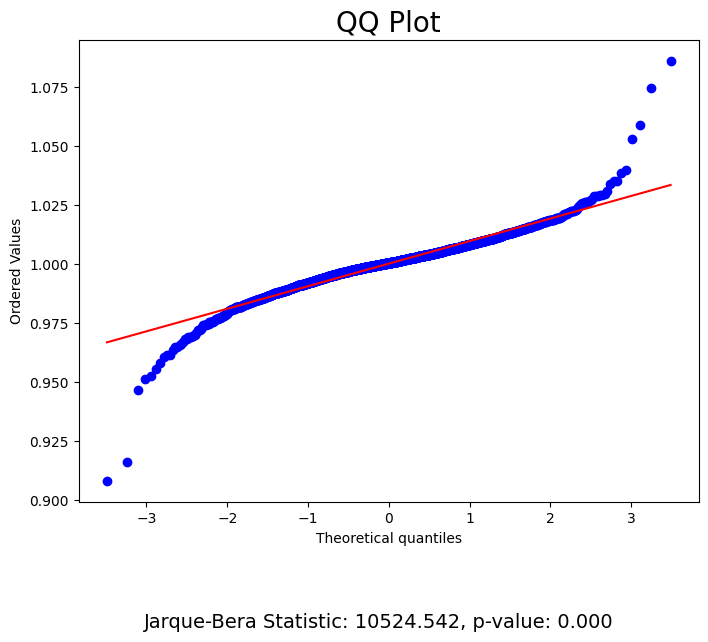

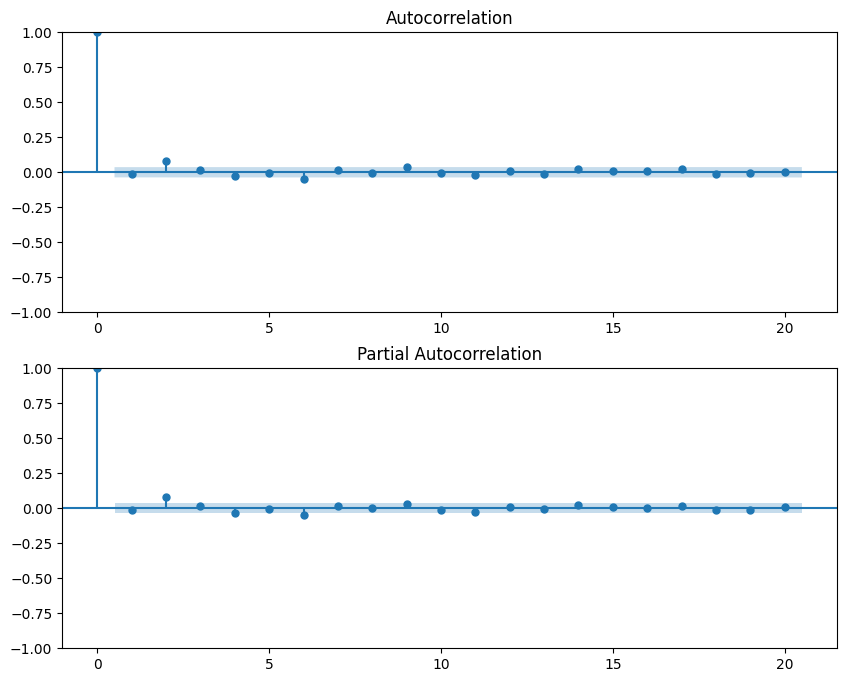


Homoscedasticity Test Results

Test used: Levene Test
Test p-value: 9.319004819260898e-20
Equal variance? No


In [119]:
# 클래스 인스턴스 생성 
tester = TimeSeriesTester(data['change']) 

tester.test_stationarity()
tester.plot_qq_plot() # This will also print Jarque-Bera Test results
tester.plot_acf_pacf()
tester.test_homoscedasticity()

- 신뢰도 상한 및 하한을 넘는 시차 : 2, 6, 14

- 사용할 데이터 : t ~ t-6일간의 변동률(과거 8일 데이터)

In [120]:
inp = data[['change','log_change']]
inp['change'] = (inp['change'] - 1)*100
print(inp)

              change  log_change
Date                            
2012-01-02 -9.196355   -0.096471
2012-01-03  2.685110    0.026497
2012-01-04 -0.490030   -0.004912
2012-01-05 -0.132888   -0.001330
2012-01-06 -1.105303   -0.011115
...              ...         ...
2023-08-03 -0.423474   -0.004244
2023-08-04 -0.099403   -0.000995
2023-08-07 -0.848705   -0.008523
2023-08-08 -0.260780   -0.002611
2023-08-09  1.209805    0.012025

[2857 rows x 2 columns]


C:\Users\이동현\AppData\Local\Temp\ipykernel_20348\136619754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp['change'] = (inp['change'] - 1)*100


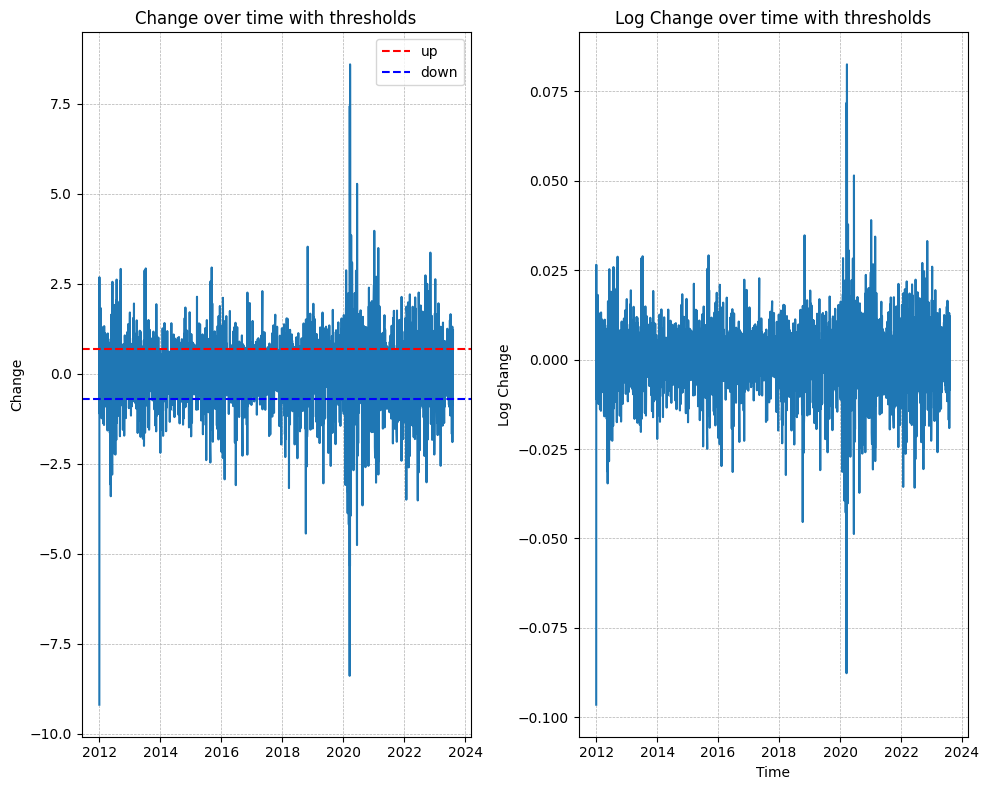

In [157]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize = (10,8))

# 첫 번째 서브플롯 (변동률)
axs[0].plot(inp['change'])
axs[0].axhline(0.7, color='r', linestyle='--', label='up')
axs[0].axhline(-0.7, color='b', linestyle='--', label='down')
axs[0].legend()
axs[0].set_title('Change over time with thresholds')
axs[0].set_ylabel('Change')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# 두 번째 서브플롯 (log 변동률, 가정: 'log_change' 컬럼)
axs[1].plot(inp['log_change'])
axs[1].set_title('Log Change over time with thresholds')
axs[1].set_ylabel('Log Change')
axs[1].set_xlabel('Time')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# 그래프 출력
plt.tight_layout()
plt.show()

In [122]:
end_date = pd.Timestamp('2021-12-30')
start_date = pd.Timestamp('2022-01-02')

train = inp.loc[:end_date]
test = inp.loc[start_date:]

print(train, test, sep = '\n\n')

              change  log_change
Date                            
2012-01-02 -9.196355   -0.096471
2012-01-03  2.685110    0.026497
2012-01-04 -0.490030   -0.004912
2012-01-05 -0.132888   -0.001330
2012-01-06 -1.105303   -0.011115
...              ...         ...
2021-12-24  0.475624    0.004745
2021-12-27 -0.427558   -0.004285
2021-12-28  0.689768    0.006874
2021-12-29 -0.892312   -0.008963
2021-12-30 -0.522507   -0.005239

[2462 rows x 2 columns]

              change  log_change
Date                            
2022-01-04  0.389236    0.003885
2022-01-05 -1.179899   -0.011869
2022-01-06 -1.132034   -0.011385
2022-01-07  1.176494    0.011696
2022-01-10 -0.953332   -0.009579
...              ...         ...
2023-08-03 -0.423474   -0.004244
2023-08-04 -0.099403   -0.000995
2023-08-07 -0.848705   -0.008523
2023-08-08 -0.260780   -0.002611
2023-08-09  1.209805    0.012025

[395 rows x 2 columns]


## train/val/test data

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

def prepare_data(data, time_window=7, threshold=0.007):
    x_data = []
    y_up_data = []
    y_down_data = []

    for i in range(len(data)-time_window):
        x_data.append(data['log_change'].values[i:i+time_window])
        change_next = data['change'].values[i+time_window]
        y_up_data.append(1 if change_next >= threshold else 0)
        y_down_data.append(1 if change_next <= -threshold else 0)
    
    return np.array(x_data), np.array(y_up_data), np.array(y_down_data)

# Preprocess train data
x_train_raw, y_up_train, y_down_train = prepare_data(train)

# Splitting into training and validation sets
x_train, x_val, y_up_train, y_up_val, y_down_train, y_down_val = train_test_split(
    x_train_raw, y_up_train, y_down_train, test_size=0.2, random_state=42)

print(x_train, y_up_train, y_down_train, sep='\n\n')

# Preprocess test data
x_test, y_up_test, y_down_test = prepare_data(test)

print(x_test, y_up_test, y_down_test, sep='\n\n')

[[-0.00660456  0.0017172   0.0020459  ...  0.0008029  -0.00132691
  -0.00500916]
 [ 0.01551959  0.00033835  0.02874687 ...  0.00130261  0.00145535
  -0.00877901]
 [-0.00914579 -0.00194479  0.00261119 ...  0.00942004  0.00243292
   0.00217289]
 ...
 [-0.00243234  0.00663409 -0.00522644 ...  0.00262339  0.00891496
   0.0065102 ]
 [ 0.001695   -0.00108047 -0.00203933 ... -0.00296165 -0.00011569
  -0.00375561]
 [-0.01434465  0.0066317   0.01135651 ... -0.00138668 -0.0242801
  -0.00666302]]

[1 1 0 ... 1 0 0]

[0 0 1 ... 0 1 1]
[[ 0.00388481 -0.01186915 -0.0113849  ... -0.00957906  0.00022545
   0.01528883]
 [-0.01186915 -0.0113849   0.01169627 ...  0.00022545  0.01528883
  -0.00350148]
 [-0.0113849   0.01169627 -0.00957906 ...  0.01528883 -0.00350148
  -0.01365422]
 ...
 [ 0.00440708  0.00173058  0.00925802 ... -0.01915445 -0.00424373
  -0.00099453]
 [ 0.00173058  0.00925802  0.01301613 ... -0.00424373 -0.00099453
  -0.00852327]
 [ 0.00925802  0.01301613 -0.01915445 ... -0.00099453 -0.0085

## Modeling

### RF

In [222]:
clf_up = RandomForestClassifier(random_state = 42)
clf_up.fit(x_train, y_up_train)

clf_down = RandomForestClassifier(random_state = 42)
clf_down.fit(x_train, y_down_train)

y_up_pred = clf_up.predict(x_val)
y_down_pred = clf_down.predict(x_val)

accuracy_up = accuracy_score(y_up_val, y_up_pred)
accuracy_down = accuracy_score(y_down_val, y_down_pred)

precision_up = precision_score(y_up_val, y_up_pred)
precision_down = precision_score(y_down_val, y_down_pred)

data = {
    'Metric': ['Accuracy', 'Precision'],
    'Up (Validation)': [accuracy_up, precision_up],
    'Down (Validation)': [accuracy_down, precision_down],
    'Up (Test)': [accuracy_score(clf_up.predict(x_test), y_up_test),
                  precision_score(clf_up.predict(x_test), y_up_test)],
    'Down (Test)': [accuracy_score(clf_down.predict(x_test), y_down_test),
                    precision_score(clf_down.predict(x_test), y_down_test)]
}

# DataFrame으로 변환
df_results = pd.DataFrame(data)
df_results = df_results.T
df_results.columns = df_results.iloc[0]
df_results = df_results.drop(df_results.index[0])
print(df_results)

Metric             Accuracy Precision
Up (Validation)    0.527495  0.565401
Down (Validation)  0.529532  0.488263
Up (Test)          0.505155  0.585859
Down (Test)        0.474227   0.31746


In [237]:
param_grid  = {
    'n_estimators': list(range(2, 10, 3)),
    'max_depth': list(range(2, 16, 4)),
    'min_samples_split': list(range(10, 26, 5)),
    'min_samples_leaf': list(range(2, 11, 3))
} 

clf_up_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf_up_grid.fit(x_train, y_up_train)
best_params_up = clf_up_grid.best_params_

clf_down_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf_down_grid.fit(x_train, y_down_train)
best_params_down = clf_down_grid.best_params_

print(best_params_up, best_params_down, sep = '\n\n')

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 8}

{'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 5}


In [238]:
clf_up = RandomForestClassifier(n_estimators = 8, max_depth = 6, min_samples_leaf = 5, 
                                min_samples_split = 20, random_state = 42)
clf_up.fit(x_train, y_up_train)

clf_down = RandomForestClassifier(n_estimators = 5, max_depth = 2, min_samples_leaf = 8, 
                                  min_samples_split = 10, random_state = 42)
clf_down.fit(x_train, y_down_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=5, random_state=42)

In [244]:
print(accuracy_score(clf_up.predict(x_test), y_up_test))
print(precision_score(clf_up.predict(x_test), y_up_test))

0.5051546391752577
0.5909090909090909


In [245]:
print(accuracy_score(clf_down.predict(x_test), y_down_test))
print(precision_score(clf_down.predict(x_test), y_down_test))

0.5
0.25396825396825395


### SVM, MLP, LGBM, XGB

In [174]:
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

clf_rf = RandomForestClassifier(random_state = 42)
clf_svm = SVC(kernel = 'poly', random_state = 42)
clf_lgbm = LGBMClassifier(random_state = 42)
clf_xgb = XGBClassifier(random_state = 42)
clf_cat = CatBoostClassifier(random_state = 42) 


classifiers = {
    'RF' : clf_rf,
    'SVM' : clf_svm,
    'LGBM': clf_lgbm,
    'XGB': clf_xgb,
    'CAT': clf_cat
}

results_up = {'Model':[], 'Accuracy':[], 'Precision':[]}
results_down = {'Model':[], 'Accuracy':[], 'Precision':[]}

for name, clf in classifiers.items():
    
    # 상승 모델
    clf.fit(x_train, y_up_train)
    y_up_pred = clf.predict(x_val)
    accuracy_up = accuracy_score(y_up_val, y_up_pred)
    precision_up = precision_score(y_up_val, y_up_pred)
    results_up['Model'].append(name)
    results_up['Accuracy'].append(accuracy_up)
    results_up['Precision'].append(precision_up)
    
    # 하락 모델
    clf.fit(x_train, y_down_train)
    y_up_pred = clf.predict(x_val)
    accuracy_up = accuracy_score(y_up_val, y_up_pred)
    precision_up = precision_score(y_up_val, y_up_pred)
    results_down['Model'].append(name)
    results_down['Accuracy'].append(accuracy_up)
    results_down['Precision'].append(precision_up)

[LightGBM] [Info] Number of positive: 1026, number of negative: 938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1964, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522403 -> initscore=0.089673
[LightGBM] [Info] Start training from score 0.089673
[LightGBM] [Info] Number of positive: 920, number of negative: 1044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1964, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468432 -> initscore=-0.126441
[LightGBM] [Info] Start training from score -0.126441
Learning rate set 

In [175]:
df_results_up = pd.DataFrame(results_up)
df_results_down = pd.DataFrame(results_down)

df_results_up

,Model,Accuracy,Precision
0,RF,0.527495,0.565401
1,SVM,0.517312,0.529279
2,LGBM,0.541752,0.576000
3,XGB,0.511202,0.548936
4,CAT,0.517312,0.551587


In [176]:
df_results_down

,Model,Accuracy,Precision
0,RF,0.470468,0.507042
1,SVM,0.462322,0.473684
2,LGBM,0.488798,0.524590
3,XGB,0.503055,0.537549
4,CAT,0.496945,0.537736


### hybrid

In [177]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

top3_up_models = list(df_results_up.sort_values(by='Precision', ascending = False).head(3)['Model'].values)
top3_down_models = list(df_results_down.sort_values(by='Precision', ascending = False).head(3)['Model'].values)
print(top3_up_models, top3_down_models)

['LGBM', 'RF', 'CAT'] ['CAT', 'XGB', 'LGBM']


In [210]:
models_dict = {
    'RF': RandomForestClassifier(random_state = 42),
    'SVM': SVC(probability=True, random_state = 42), # To use VotingClassifier, probability needs to be set to True for SVM
    'XGB': XGBClassifier(random_state = 42),
    'CAT': CatBoostClassifier(random_state = 42),
    'LGBM': LGBMClassifier(random_state = 42)
}

top3_up_classifiers = [(model, models_dict[model]) for model in top3_up_models]
top3_down_classifiers = [(model, models_dict[model]) for model in top3_down_models]

print(top3_up_classifiers)
print(top3_down_classifiers)

[('LGBM', LGBMClassifier(random_state=42)), ('RF', RandomForestClassifier(random_state=42)), ('CAT', <catboost.core.CatBoostClassifier object at 0x000001ADB4AEA150>)]
[('CAT', <catboost.core.CatBoostClassifier object at 0x000001ADB4AEA150>), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...))

In [220]:
hybrid_results_up = {'Model':[], 'Accuracy':[], 'Precision':[]}
hybrid_results_down = {'Model':[], 'Accuracy':[], 'Precision':[]}

# Voting
voting_clf_soft_up = VotingClassifier(estimators=top3_up_classifiers, voting='soft')
voting_clf_soft_down = VotingClassifier(estimators=top3_down_classifiers, voting='soft')

voting_clf_hard_up = VotingClassifier(estimators=top3_up_classifiers, voting='hard')
voting_clf_hard_down = VotingClassifier(estimators=top3_down_classifiers, voting='hard')

# Weighted Voting
weights = [0.4, 0.4, 0.2]
voting_weighted_clf_up = VotingClassifier(estimators=top3_up_classifiers, voting='soft', weights=weights)
voting_weighted_clf_down = VotingClassifier(estimators=top3_down_classifiers, voting='soft', weights=weights)

# Stacking
stacking_clf_up = StackingClassifier(estimators=top3_up_classifiers, final_estimator=LogisticRegression())
stacking_clf_down = StackingClassifier(estimators=top3_down_classifiers, final_estimator=LogisticRegression())

extended_classifiers = {
    'Voting_Soft_Up': voting_clf_soft_up,
    'Voting_Soft_Down': voting_clf_soft_down,
    'Voting_Hard_Up': voting_clf_hard_up,
    'Voting_Hard_Down': voting_clf_hard_down,
    'Weighted_Voting_Up': voting_weighted_clf_up,
    'Weighted_Voting_Down': voting_weighted_clf_down,
    'Stacking_Up': stacking_clf_up,
    'Stacking_Down': stacking_clf_down
}

for name, clf in extended_classifiers.items():
    # Check if the classifier is for upward or downward trend
    if "Up" in name:
        clf.fit(x_train, y_up_train)
        y_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_up_val, y_pred)
        precision = precision_score(y_up_val, y_pred)
        hybrid_results_up['Model'].append(name)
        hybrid_results_up['Accuracy'].append(accuracy)
        hybrid_results_up['Precision'].append(precision)
    else:
        clf.fit(x_train, y_down_train)
        y_pred = clf.predict(x_val)
        accuracy = accuracy_score(y_down_val, y_pred)
        precision = precision_score(y_down_val, y_pred)
        hybrid_results_down['Model'].append(name)
        hybrid_results_down['Accuracy'].append(accuracy)
        hybrid_results_down['Precision'].append(precision)

hybrid_results_up_df = pd.DataFrame(hybrid_results_up)
hybrid_results_down_df = pd.DataFrame(hybrid_results_down)

[LightGBM] [Info] Number of positive: 1026, number of negative: 938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1964, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522403 -> initscore=0.089673
[LightGBM] [Info] Start training from score 0.089673
Learning rate set to 0.013744
0:	learn: 0.6926396	total: 2.32ms	remaining: 2.32s
1:	learn: 0.6920645	total: 3.96ms	remaining: 1.98s
2:	learn: 0.6915035	total: 5.58ms	remaining: 1.85s
3:	learn: 0.6909834	total: 7.27ms	remaining: 1.81s
4:	learn: 0.6906169	total: 8.68ms	remaining: 1.73s
5:	learn: 0.6898338	total: 10.3ms	remaining: 1.7s
6:	learn: 0.6893261	total: 11.8ms	remaining: 1.68s
7:	learn: 0.6889141	total: 13.4ms	remaining: 1.66s
8:	learn: 0.6886144	total: 14.9ms	remaining: 1.64s
9:	learn: 0.6881485	to

In [221]:
print(df_results_up, df_results_down, hybrid_results_up_df, hybrid_results_down_df, sep = '\n\n')

  Model  Accuracy  Precision
0    RF  0.527495   0.565401
1   SVM  0.517312   0.529279
2  LGBM  0.541752   0.576000
3   XGB  0.511202   0.548936
4   CAT  0.517312   0.551587

  Model  Accuracy  Precision
0    RF  0.470468   0.507042
1   SVM  0.462322   0.473684
2  LGBM  0.488798   0.524590
3   XGB  0.503055   0.537549
4   CAT  0.496945   0.537736

                Model  Accuracy  Precision
0      Voting_Soft_Up  0.529532   0.565574
1      Voting_Hard_Up  0.525458   0.560976
2  Weighted_Voting_Up  0.531568   0.566802
3         Stacking_Up  0.547862   0.559078

                  Model  Accuracy  Precision
0      Voting_Soft_Down  0.521385   0.481328
1      Voting_Hard_Down  0.482688   0.439655
2  Weighted_Voting_Down  0.511202   0.470588
3         Stacking_Down  0.523422   0.462264


## Test 확인

### 상승

In [215]:
def predict_test(classifier, x_test, y_test):
    results = {'Model': [], 'Accuracy': [], 'Precision': []}
    
    for name, clf in classifier.items():
        y_pred = clf.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        results['Model'].append(name)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        
    df_results = pd.DataFrame(results)
    
    return print(df_results, sep = '\n\n')

In [216]:
predict_test(classifiers, x_test, y_up_test)

  Model  Accuracy  Precision
0    RF  0.528351   0.555556
1   SVM  0.479381   0.458333
2  LGBM  0.487113   0.496689
3   XGB  0.466495   0.468966
4   CAT  0.489691   0.500000


In [217]:
predict_test(extended_classifiers, x_test, y_up_test)

                  Model  Accuracy  Precision
0        Voting_Soft_Up  0.502577   0.510730
1      Voting_Soft_Down  0.476804   0.483871
2        Voting_Hard_Up  0.507732   0.515419
3      Voting_Hard_Down  0.484536   0.493333
4    Weighted_Voting_Up  0.502577   0.510730
5  Weighted_Voting_Down  0.476804   0.483871
6           Stacking_Up  0.530928   0.527586
7         Stacking_Down  0.487113   0.492308


### 하락

In [218]:
predict_test(classifiers, x_test, y_down_test)

  Model  Accuracy  Precision
0    RF  0.474227   0.444444
1   SVM  0.523196   0.541667
2  LGBM  0.515464   0.503311
3   XGB  0.536082   0.531034
4   CAT  0.512887   0.500000


In [219]:
predict_test(extended_classifiers, x_test, y_down_test)

                  Model  Accuracy  Precision
0        Voting_Soft_Up  0.494845   0.484979
1      Voting_Soft_Down  0.525773   0.516129
2        Voting_Hard_Up  0.489691   0.480176
3      Voting_Hard_Down  0.518041   0.506667
4    Weighted_Voting_Up  0.494845   0.484979
5  Weighted_Voting_Down  0.525773   0.516129
6           Stacking_Up  0.466495   0.468966
7         Stacking_Down  0.515464   0.507692
